In [42]:
import numpy as np
import pandas as pd

In [43]:
df = pd.read_csv("/content/Fraud Detection Dataset.csv")
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

In [45]:
#Check for missing data points
df.isnull().sum()

,0
Transaction_ID,0
User_ID,0
Transaction_Amount,2520
Transaction_Type,0
Time_of_Transaction,2552
Device_Used,2473
Location,2547
Previous_Fraudulent_Transactions,0
Account_Age,0
Number_of_Transactions_Last_24H,0


In [46]:
# For object columns
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# For numeric columns
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

In [47]:
#Check the dataset for missing values again
df.isnull().sum()

,0
Transaction_ID,0
User_ID,0
Transaction_Amount,0
Transaction_Type,0
Time_of_Transaction,0
Device_Used,0
Location,0
Previous_Fraudulent_Transactions,0
Account_Age,0
Number_of_Transactions_Last_24H,0


In [48]:
# Drop the USERID
df = df.drop("User_ID", axis=1)

In [49]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Apply label encoding to each object-type column
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Now apply scaling
scaler = StandardScaler()
scaled_array = scaler.fit_transform(df)

In [102]:
#ISOLATION FOREST
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination= 0.085, random_state = 42)
preds = iso_forest.fit_predict(scaled_array)

In [103]:
#Add anomaly labels
df["Anomalies"] = preds

In [104]:
#The Anomally counts
print(df["Anomalies"].value_counts())

Anomalies
 1    46665
-1     4335
Name: count, dtype: int64


In [105]:
#Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

anomaly_labels = [1 if x == 1 else 0 for x in df["Anomalies"]]
#Convert Fraudulent column to match the anomally labels
fraudulent_labels = 1 - df["Fraudulent"]

#Define the metrics
precision = precision_score(fraudulent_labels, anomaly_labels)
recall = recall_score(fraudulent_labels, anomaly_labels)
f1 = f1_score(fraudulent_labels, anomaly_labels)
accuracy = accuracy_score(fraudulent_labels, anomaly_labels)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.9964855887710276
Recall: 0.9589812332439678
F1 Score: 0.9773737586043824
Accuracy: 0.9577843137254902


In [106]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(fraudulent_labels, anomaly_labels))

              precision    recall  f1-score   support

           0       0.54      0.93      0.69      2510
           1       1.00      0.96      0.98     48490

    accuracy                           0.96     51000
   macro avg       0.77      0.95      0.83     51000
weighted avg       0.97      0.96      0.96     51000



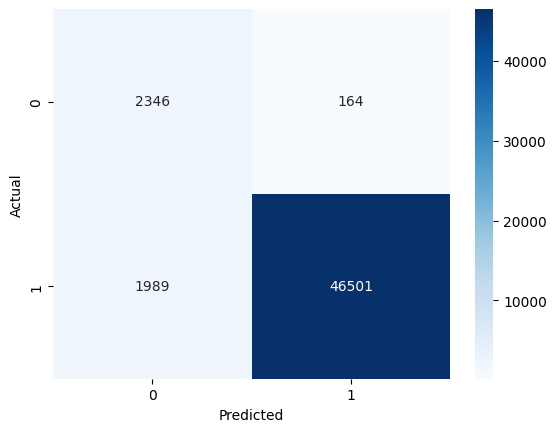

In [107]:
#Confusion matrix heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(fraudulent_labels, anomaly_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()